In [1]:
from qutip import *
from qutip.qip.operations import *
import numpy as np
import matplotlib.pyplot as plt
import datetime
import random
from random import random 
%matplotlib inline

# Ramsey (Carrier)
## wait time scan
$$
\newcommand{\ket}[1]{\left|{#1}\right\rangle}
\newcommand{\bra}[1]{\left\langle{#1}\right|}
$$
Steps:
1. Apply $\pi/2$ of carrier.
2. Wait a period of time $\tau$.
3. Apply $\pi/2$ of carrier.
4. Measure Prob($\ket{1}$).
5. Repeat step of 1-4 to scan the wait time to get the Prob($\ket{1}$) vs. wait time figure.

In [99]:
#coherence time
def Ramsey_wait(waitTimeList, t0, Delta, c_ops = []):
    finalState = []
    for tau in waitTimeList:
        Omega = 0.125*2*np.pi/t0

        ## First step
        t_start = 0
        t_stop = t0 # ms
        N_sample = 100

        H1 = Omega*sigmax()+Delta*sigmaz()
        s_init = basis(2,1)
        t_list = np.linspace(t_start, t_stop, N_sample)

        output = mesolve(H1, s_init, t_list, c_ops, [])
        s1 = output.states[-1]

        ## Second step
        t_start = 0
        t_stop = tau # wait time
        N_sample = 200

        H2 = Delta*sigmaz()
        s_init = s1
        t_list = np.linspace(t_start, t_stop, N_sample)

        output = mesolve(H2, s_init, t_list, c_ops, [])

        s2 = output.states[-1]

        ## Third step
        t_start = 0
        t_stop = t0 # ms
        N_sample = 100

        H3 = Omega*sigmax()+Delta*sigmaz()
        s_init = s2
        t_list = np.linspace(t_start, t_stop, N_sample)
        e_ops = sigmaz()
        
        output = mesolve(H3, s_init, t_list, c_ops, e_ops)
        #s3 = output.states[-1]
        s3z = output.expect[0][-1]
        finalState.append(s3z)
    plt.plot(waitTimeList, finalState)

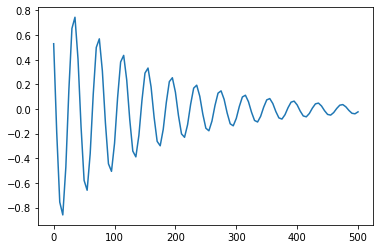

In [104]:
#coherence time
tau_c = 300 # us coherence time
c_ops = np.sqrt(1/(tau_c))*sigmaz()

t0 = 5 # us, pi/2 time
Omega = 0.125*2*np.pi/t0
Delta = 0.5* Omega # detuning

waitTimeList = np.linspace(0.01,500,101)
Ramsey_wait(waitTimeList, t0, Delta, c_ops)

# Scan phase

In [76]:
#coherence time
def Ramsey_scanPhase(waitTimeList, t0, Delta, c_ops = []):
    phases = np.linspace(0,2*np.pi, 73)
    Contrasts = []
    for tau in waitTimeList:
        now1 = datetime.datetime.now()
        Omega = 0.125*2*np.pi/t0

        ## First step
        t_start = 0
        t_stop = t0 
        N_sample = 100

        H1 = Omega*sigmax()+Delta*sigmaz()

        s_init = basis(2,1)
        t_list = np.linspace(t_start, t_stop, N_sample)

        output = mesolve(H1, s_init, t_list, c_ops, [])
        s1 = output.states[-1]

        ## Second step
        t_start = 0
        t_stop = tau # wait time
        N_sample = 200

        H2 = Delta*sigmaz()
        s_init = s1
        t_list = np.linspace(t_start, t_stop, N_sample)

        output = mesolve(H1, s_init, t_list, c_ops, [])

        s2 = output.states[-1]
        
        finalState = []
        for phi_s in phases:
            ## Third step
            t_start = 0
            t_stop = t0 # ms
            N_sample = 100

            sp = destroy(2)
            sm = create(2)
            H3 = Omega*sp*np.exp(1j*phi_s)\
                +Omega*sm*np.exp(-1j*phi_s)\
                +Delta*sigmaz()

            s_init = s2
            t_list = np.linspace(t_start, t_stop, N_sample)
            e_ops = sigmaz()

            output = mesolve(H3, s_init, t_list, c_ops, e_ops)
            s3z = output.expect[0][-1]
            finalState.append(s3z)
        Contrasts.append((max(finalState)-min(finalState))/2)
    now2 = datetime.datetime.now()
    print(now2-now1)
    return Contrasts

0:00:00.562411


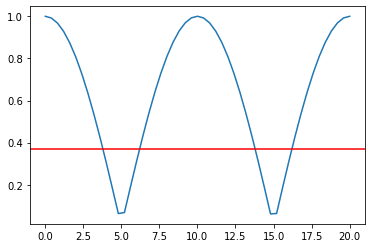

In [80]:
t0 = 5 # us, pi/2 time
Omega = 0.125*2*np.pi/t0
Delta = 0.01* Omega # constant detuning

waitTimeList = np.linspace(0.01,20,51)
Contrasts = Ramsey_scanPhase(waitTimeList, t0, Delta)
plt.plot(waitTimeList, Contrasts)
plt.axhline(y=0.36787944117, color='r', linestyle='-')

0:00:00.420960


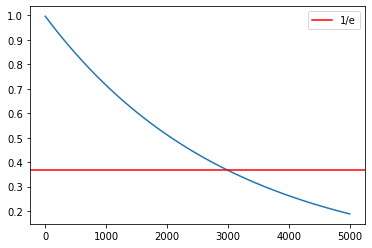

In [81]:
#coherence time
tau_c = 3000 # us coherence time
c_ops = np.sqrt(1/(tau_c))*sigmaz()

t0 = 5 # us, pi/2 time
Omega = 0.125*2*np.pi/t0
Delta = 0* Omega

waitTimeList = np.linspace(0.001,5000,51)
Contrasts = Ramsey_scanPhase(waitTimeList, t0, Delta, c_ops = c_ops)
plt.plot(waitTimeList, Contrasts)
plt.axhline(y=0.36787944117, color='r', linestyle='-', label = '1/e')
plt.legend()

0:00:00.363285


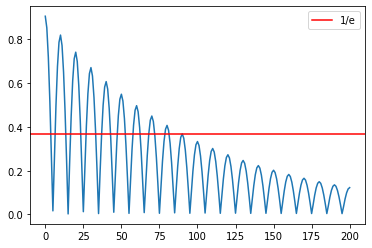

In [91]:
#coherence time
tau_c = 100 # us coherence time
c_ops = np.sqrt(1/(tau_c))*sigmaz()

t0 = 5 # us, pi/2 time
Omega = 0.125*2*np.pi/t0
Delta = 0.01* Omega

waitTimeList = np.linspace(0.001,200,201)
Contrasts = Ramsey_scanPhase(waitTimeList, t0, Delta, c_ops = c_ops)
plt.plot(waitTimeList, Contrasts)
plt.axhline(y=0.36787944117, color='r', linestyle='-', label = '1/e')
plt.legend()

# Ramsey (2 ion motion)
$$
\newcommand{\ket}[1]{\left|{#1}\right\rangle}
\newcommand{\bra}[1]{\left\langle{#1}\right|}
$$
Steps:
1. Apply $\pi/2$ of BSB.
2. Wait a period of time $\tau$.
3. Apply $\pi/2$ of BSB with a phase $\phi_s$
4. Scan the phase to get a Prob($\ket{1}$) vs. phase figure.
5. Scan the wait time to get more figures in step 4.

NOTE: This part is for testing, I want to have a look at the final state of each step. You can skip this part and junp to the `Ramsey (Motion)` part.

In [685]:
#coherence time
tau_c = 3 # coherence time
c_ops = np.sqrt(1/(2*tau_c))*sigmaz()
sp = destroy(2)
sm = create(2)

In [2]:
def plot(t_list, output, axis = 'z', isketstate = True):
    if isketstate:
        if axis == 'z':
            Sz = []
            for state in output.states:
                Sz.append((state.dag()*sigmaz()*state).data[0,0])
            plt.plot(t_list, Sz)
            plt.xlabel('Time (ms)')
            plt.ylabel('Sz')
            plt.show()
        if axis == 'x':
            Sx = []
            for state in output.states:
                Sx.append((state.dag()*sigmax()*state).data[0,0])
            plt.plot(t_list, Sx)
            plt.xlabel('Time (ms)')
            plt.ylabel('Sx')
            plt.show()
        if axis == 'y':
            Sy = []
            for state in output.states:
                Sy.append((state.dag()*sigmay()*state).data[0,0])
            plt.plot(t_list, Sy)
            plt.xlabel('Time (ms)')
            plt.ylabel('Sy')
            plt.show()
    else:
        if axis == 'z':
            Sz = []
            for state in output.states:
                Sz.append((sigmaz()*state).tr())
            plt.plot(t_list, Sz)
            plt.xlabel('Time (ms)')
            plt.ylabel('Sz')
            plt.show()
        if axis == 'x':
            Sx = []
            for state in output.states:
                Sx.append((sigmax()*state).tr())
            plt.plot(t_list, Sx)
            plt.xlabel('Time (ms)')
            plt.ylabel('Sx')
            plt.show()
        if axis == 'y':
            Sy = []
            for state in output.states:
                Sy.append((sigmay()*state).tr())
            plt.plot(t_list, Sy)
            plt.xlabel('Time (ms)')
            plt.ylabel('Sy')
            plt.show()

#### First Step:

In [654]:
t0 = 2.5e-3 # ms, pi/2 time
Omega = 0.125*2*np.pi/t0

t_start = 0
t_stop = t0 # ms
N_sample = 100

def epsilon(t):
    noise_amp = 4*2*np.pi
    noise_freq = 3*2*np.pi
    return noise_amp*np.sin(noise_freq*t)
H01 = Omega*sp
def H01_coeff(t, args):
    w = Omega*0.001
    #return np.exp(1j*epsilon(t)*t)
    #return np.sin(w*t)
    return 1
H02 = Omega*sm
def H02_coeff(t, args):
    #return np.exp(-1j*epsilon(t)*t)
    w = Omega*0.001
    #return np.sin(w*t)
    return 1
s_init = basis(2,1)
t_list = np.linspace(t_start, t_stop, N_sample)
e_ops = [sigmaz(), sigmax()]

now1 = datetime.datetime.now()
output = mesolve([[H01, H01_coeff], [H02, H02_coeff]], s_init, t_list, [], [])
#output = mesolve([[H01, H01_coeff], [H02, H02_coeff]], s_init, t_list, c_ops, e_ops)
now2 = datetime.datetime.now()
print(now2-now1)
'''
Sz = output.expect[0]
plt.plot(t_list, Sz)
plt.show()
Sx = output.expect[1]
plt.plot(t_list, Sx)
plt.show()'''
s1 = output.states[-1]
s1

0:00:00.103972


Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[0.        -0.70710498j]
 [0.70710859+0.j        ]]

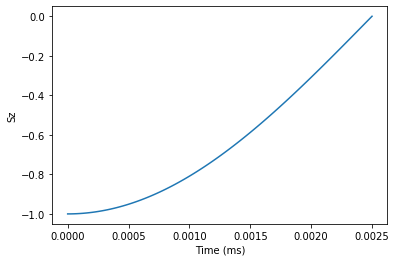

In [655]:
plot(t_list, output, axis = 'z', isketstate = True)

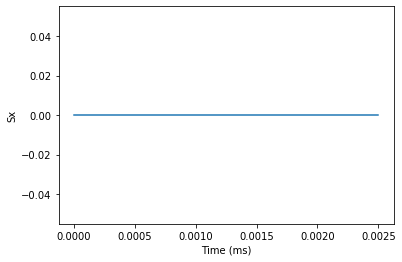

In [656]:
plot(t_list, output, axis = 'x', isketstate = True)

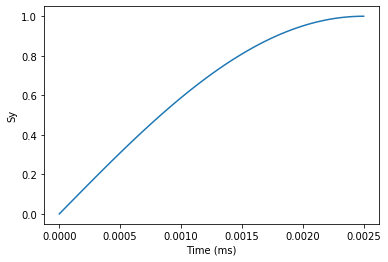

In [657]:
plot(t_list, output, axis = 'y', isketstate = True)

#### Second Step: waiting for $\tau$

In [598]:
Nsample = 10
freq_l = freq_filter[0]
freq_h = freq_filter[1]
freqs = [freq_l+random()*(freq_h-freq_l) for i in range(Nsample)]
phis = [random()*2*np.pi for i in range(Nsample)]

def Whitenoise(t):
    T = 0
    for i in range(Nsample):
        T+=Omega*np.sin(2*np.pi*freqs[i]*t+phis[i])/Nsample
    return T

t_start = 0
t_stop = 10
N_sample = 200

H1 = 0.01*Omega*sigmaz()
phi = random()*2*np.pi
def H1_coeff(t, args):
    w = 0.06*2*np.pi
    return np.sin(w*t+phi)
    #return Whitenoise(t)
s_init = s1
t_list = np.linspace(t_start, t_stop, N_sample)
e_ops = sigmax()

now1 = datetime.datetime.now()
#output = mesolve(qeye(2), s_init, t_list, c_ops, e_ops)
#output = mesolve([H1, H1_coeff], s_init, t_list, c_ops, [])
output = mesolve(qeye(2), s_init, t_list, c_ops, [])
now2 = datetime.datetime.now()
print(now2-now1)

'''Sx = output.expect[0]
plt.plot(t_list, Sx)
'''
s2 = output.states[-1]
s2

0:00:00.015201


Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.49999745+0.j         0.        -0.01783712j]
 [0.        +0.01783712j 0.50000255+0.j        ]]

In [597]:
(s2*s2).tr()

0.9966777479403627

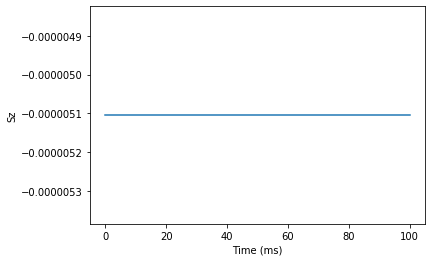

In [594]:
plot(t_list, output, axis = 'z', isketstate = False)

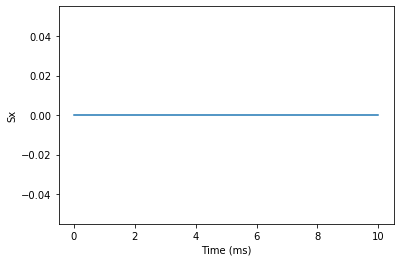

In [591]:
plot(t_list, output, axis = 'x', isketstate = False)

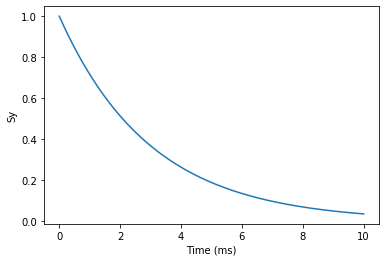

In [592]:
plot(t_list, output, axis = 'y', isketstate = False)

#### Third Step:

0:00:00.009401


's1 = output.states[-1]\ns1'

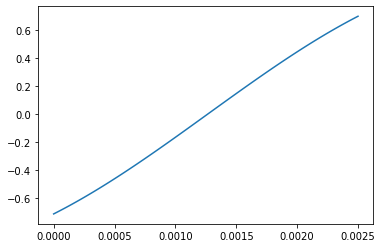

In [557]:
t_start = 0
t_stop = t0 # ms
N_sample = 100

phi_s = 0/10*np.pi

H21 = Omega*sp
def H21_coeff(t, args):
    #return np.exp(1j*(epsilon(t)*t+phi_s))
    return 1
H22 = Omega*sm
def H22_coeff(t, args):
    #return np.exp(-1j*(epsilon(t)*t+phi_s))
    return 1
    
s_init = s2
t_list = np.linspace(t_start, t_stop, N_sample)
e_ops = sigmaz()

now1 = datetime.datetime.now()
output = mesolve([[H21, H21_coeff], [H22, H22_coeff]], s_init, t_list, c_ops, e_ops)
now2 = datetime.datetime.now()
print(now2-now1)

Sz = output.expect[0]
plt.plot(t_list, Sz)
'''s1 = output.states[-1]
s1'''

0:00:00.009156
0:00:00.008507
0:00:00.008202
0:00:00.008467
0:00:00.009075
0:00:00.009222
0:00:00.009891
0:00:00.009923
0:00:00.009049
0:00:00.008308
0:00:00.007713
0:00:00.007220
0:00:00.007404
0:00:00.006822
0:00:00.006709


Text(0.5, 0, 'Contrast')

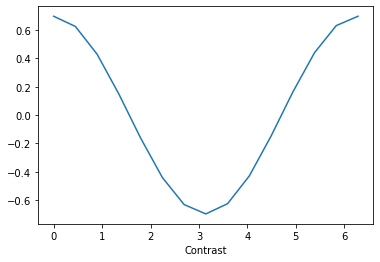

In [558]:
phi_s_list = np.linspace(0, 2*np.pi, 15)
res = []
for phi in phi_s_list:
    t_start = 0
    t_stop = t0 # ms
    N_sample = 100

    H21 = Omega*sp
    def H21_coeff(t, args):
        #return np.exp(1j*(epsilon(t)*t+phi))
        return np.exp(1j*phi)
    H22 = Omega*sm
    def H22_coeff(t, args):
        #return np.exp(-1j*(epsilon(t)*t+phi))
        return np.exp(-1j*phi)
    
    s_init = s2
    t_list = np.linspace(t_start, t_stop, N_sample)
    c_ops = np.sqrt(1/tau_c)*sigmaz()
    e_ops = sigmaz()

    now1 = datetime.datetime.now()
    output = mesolve([[H21, H21_coeff], [H22, H22_coeff]], s_init, t_list, c_ops, e_ops)
    now2 = datetime.datetime.now()
    print(now2-now1)

    Sz = output.expect[0]
    '''plt.plot(t_list, Sz)
    plt.show()'''
    '''s1 = output.states[-1]
    s1'''
    res.append(Sz[-1])
plt.plot(phi_s_list, res)   
plt.xlabel('Phi_s')
plt.ylabel('Contrast')

# Ramsey (Motion)

In [4]:
#coherence time
tau_l = 300 # laser coherence time
tau_m = 3 # motional coherence time
N = 5
a = destroy(N)
adag = create(N)

c_ops = [np.sqrt(1/(2*tau_l))*tensor(sigmaz(),qeye(N)), np.sqrt(2/(tau_m))*tensor(qeye(2), adag*a)]
sp = destroy(2)
sm = create(2)

In [39]:
def Ramsey_motion(phi_s, tau):  
    
    # Detuning model:
    def Delta(t):
        delta = 0.1*2*np.pi # detunning amp, kHz
        omega = 0.2*2*np.pi# detunning amp, kHz
        phi = 0*2*np.pi
        return delta*np.sin(omega*t+phi)
    # First step:
    t0 = 0.06 # ms, pi/2 time
    Omega = 0.125*2*np.pi/t0

    t_start = 0
    t_stop = t0 
    N_sample = 100
    
    phi_n = random()*2*np.pi
    H01 = tensor(sp, adag)
    def H01_coeff(t, args):
        return np.sqrt(Omega**2+Delta(t)**2)
    H02 = tensor(sm, a)
    def H02_coeff(t, args):
        return np.sqrt(Omega**2+Delta(t)**2)
    H03 = tensor(sigmaz(), qeye(N))
    def H03_coeff(t, args):
        return Delta(t)
    s_init = tensor(ket2dm(basis(2,1)), thermal_dm(N,0.1))
    t_list = np.linspace(t_start, t_stop, N_sample)
    output = mesolve([[H01, H01_coeff], [H02, H02_coeff],[H03, H03_coeff]], s_init, t_list, c_ops, [])

    s1 = output.states[-1]

    # Second step:
    ## White noise
    Nfreq = 10  # This affacts the running time a lot
    freq_filter = [0.001, 1000]
    freq_l = freq_filter[0]
    freq_h = freq_filter[1]
    freqs = [freq_l+random()*(freq_h-freq_l) for i in range(Nfreq)]
    phis = [random()*2*np.pi for i in range(Nfreq)]
    def Whitenoise(t):
        T = 0
        for i in range(Nfreq):
            T+=np.sin(2*np.pi*freqs[i]*t+phis[i])/Nfreq*Omega
        return T
    
    if tau == 0:
        s2 = s1
    else:
        t_start = 0
        t_stop = tau
        N_sample = 500
        t_list = np.linspace(t_start, t_stop, N_sample)
        s_init = s1
        
        H1 = tensor(sigmaz(),qeye(N))
        def H1_coeff(t, args):
            return Delta(t)
        '''
        def H1_coeff(t, args):
            return Whitenoise(t)'''

        output = mesolve([H1, H1_coeff], s_init, t_list, c_ops, [])
        #output = mesolve(tensor(qeye(2),qeye(N)), s_init, t_list, c_ops, [])
        s2 = output.states[-1]
    
    # Third step:
    t_start = 0
    t_stop = t0
    N_sample = 100
    t_list = np.linspace(t_start, t_stop, N_sample)
    
    phi_n = random()*2*np.pi
    H21 = tensor(sp, adag)
    def H21_coeff(t, args):
        return np.exp(1j*phi_s)*np.sqrt(Omega**2+Delta(t)**2)
    H22 = tensor(sm, a)
    def H22_coeff(t, args):
        return np.exp(-1j*phi_s)*np.sqrt(Omega**2+Delta(t)**2)
    H23 = tensor(sigmaz(), qeye(N))
    def H23_coeff(t, args):
        return Delta(t)
    s_init = s2
    output = mesolve([[H21, H21_coeff], [H22, H22_coeff],[H23, H23_coeff]], \
                     s_init, t_list, c_ops, [tensor(sigmaz(),qeye(N))])

    s3 = (output.expect[0][-1]+1)/2
    return s3


def scan_wait_time_and_phase():
    phi_s_list = np.linspace(0, 2*np.pi, 51)
    tau_list = np.linspace(0,4,41)
    contrast = []
    now1 = datetime.datetime.now()
    for tau in tau_list:
        print('tau = '+str(tau)+' ms')
        probs = []
        for phi_s in phi_s_list:
            probs.append(Ramsey_motion(phi_s, tau))
        label = 'tau = '+str(tau)
        plt.plot(phi_s_list, probs, label = label)
        plt.xlabel('Wait time (ms)')
        plt.ylabel('Porb of excited state')
        plt.legend()
        plt.ylim([-0.1,1.1])
        plt.show()
        contrast.append(max(probs)-min(probs))    
    now2 = datetime.datetime.now()
    print('time used: '+str(now2-now1)+'s')
    plt.figure()
    plt.plot(tau_list, contrast)
    plt.plot(tau_list, [1/np.exp(1) for i in range(len(tau_list))])
    plt.xlabel('Wait time (ms)')
    plt.ylabel('Contrast')
    plt.ylim([-0.1,1.1])
    
def scan_wait_time():
    tau_list = np.linspace(0,8,41)
    probs = []
    for tau in tau_list:
        probs.append(Ramsey_motion(0, tau))
    plt.plot(tau_list, probs)
    plt.xlabel('Wait time (ms)')
    plt.ylabel('Porb of excited state')
    plt.ylim([-0.1,1.1])

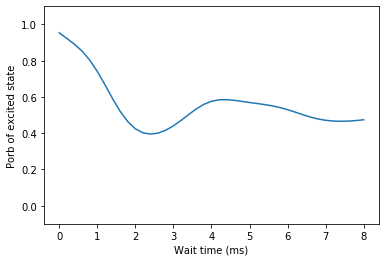

In [38]:
scan_wait_time()

tau = 0.0 ms


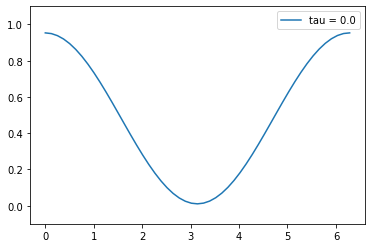

tau = 0.1 ms


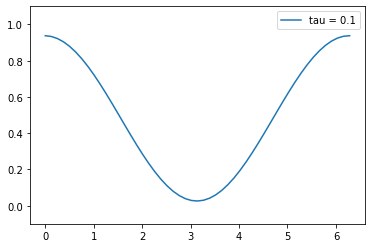

tau = 0.2 ms


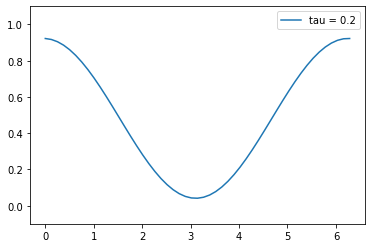

tau = 0.30000000000000004 ms


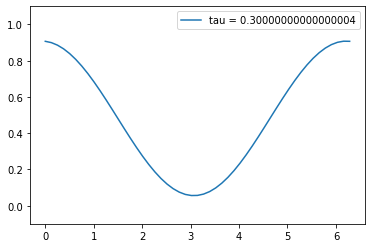

tau = 0.4 ms


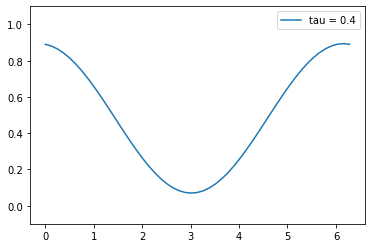

tau = 0.5 ms


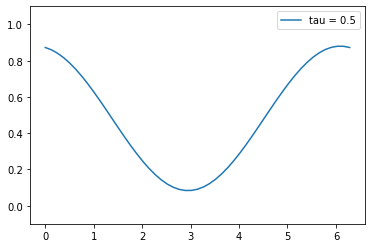

tau = 0.6000000000000001 ms


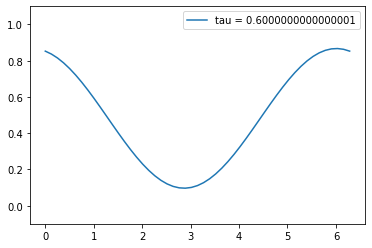

tau = 0.7000000000000001 ms


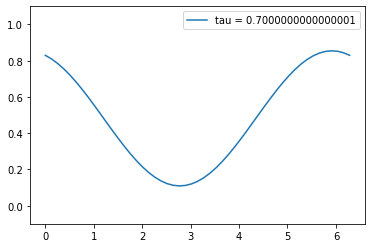

tau = 0.8 ms


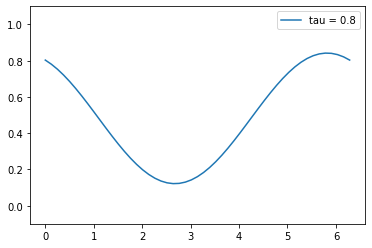

tau = 0.9 ms


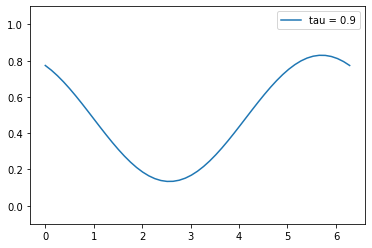

tau = 1.0 ms


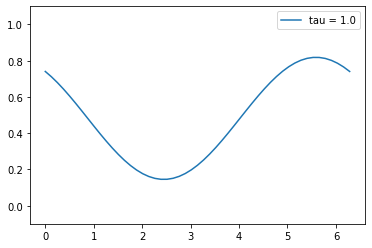

tau = 1.1 ms


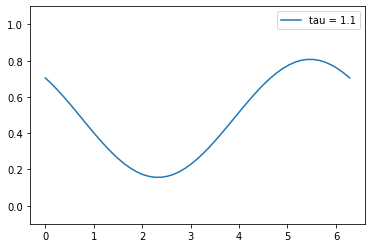

tau = 1.2000000000000002 ms


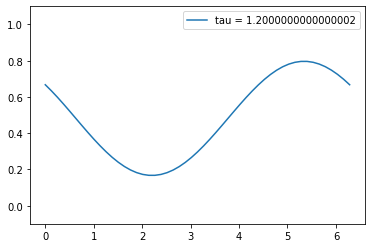

tau = 1.3 ms


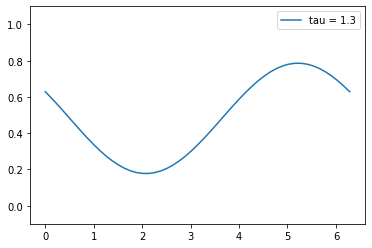

tau = 1.4000000000000001 ms


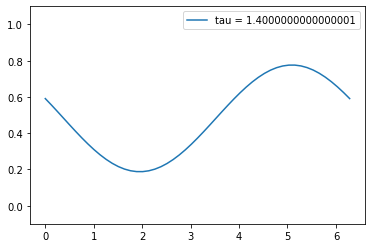

tau = 1.5 ms


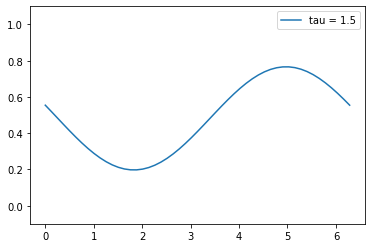

tau = 1.6 ms


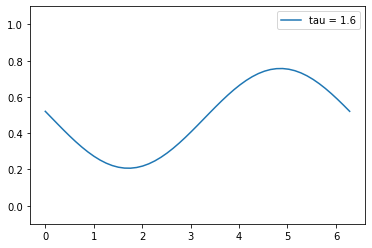

tau = 1.7000000000000002 ms


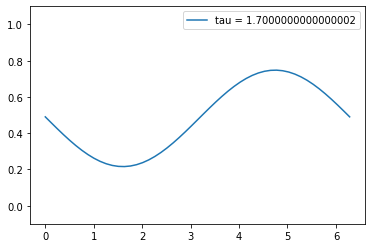

tau = 1.8 ms


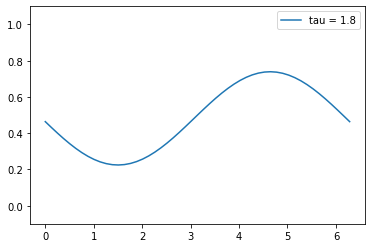

tau = 1.9000000000000001 ms


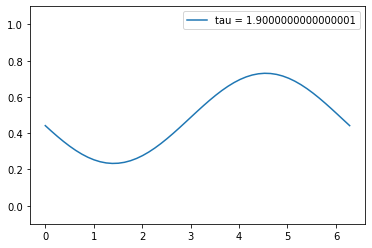

tau = 2.0 ms


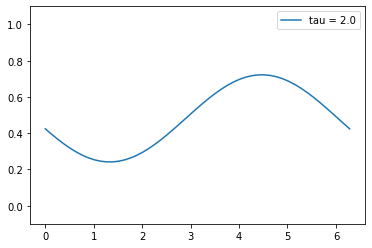

tau = 2.1 ms


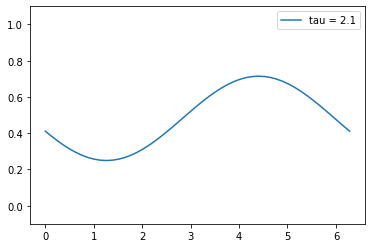

tau = 2.2 ms


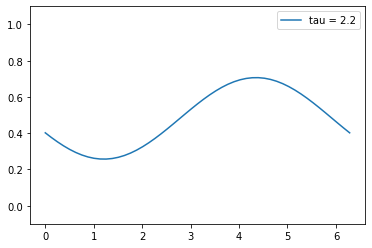

tau = 2.3000000000000003 ms


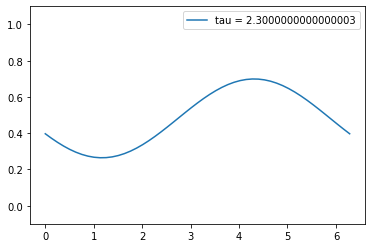

tau = 2.4000000000000004 ms


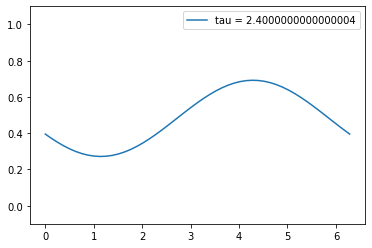

tau = 2.5 ms


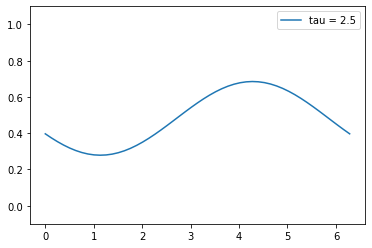

tau = 2.6 ms


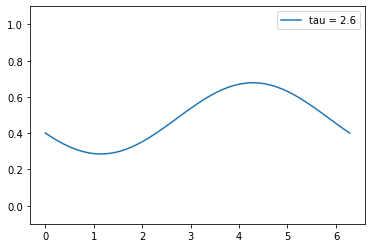

tau = 2.7 ms


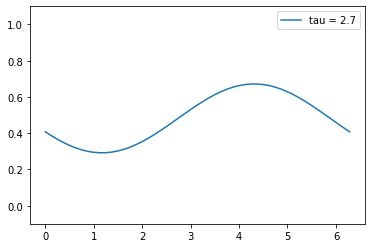

tau = 2.8000000000000003 ms


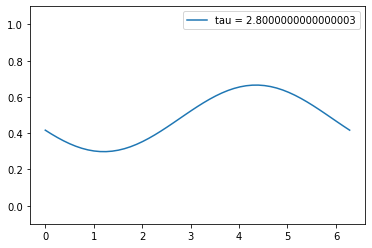

tau = 2.9000000000000004 ms


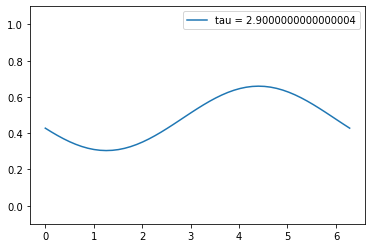

tau = 3.0 ms


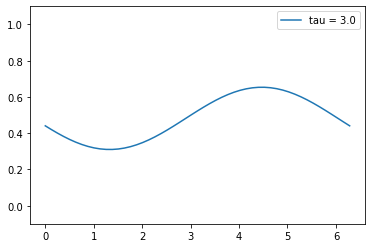

tau = 3.1 ms


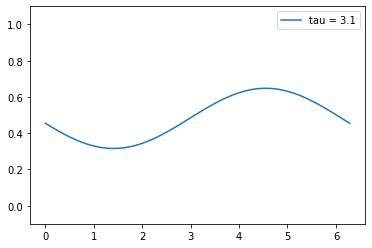

tau = 3.2 ms


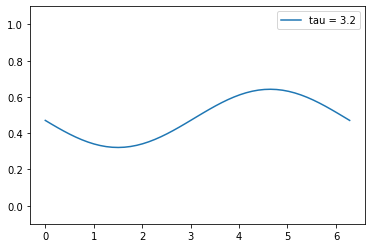

tau = 3.3000000000000003 ms


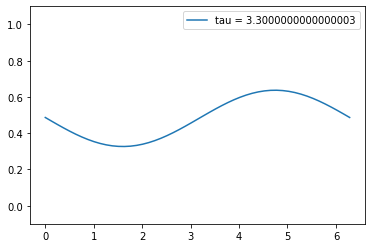

tau = 3.4000000000000004 ms


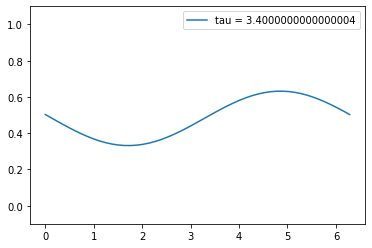

tau = 3.5 ms


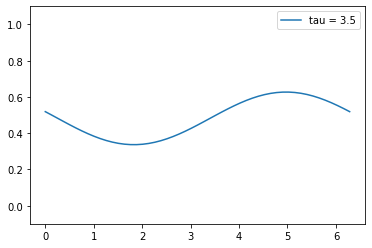

tau = 3.6 ms


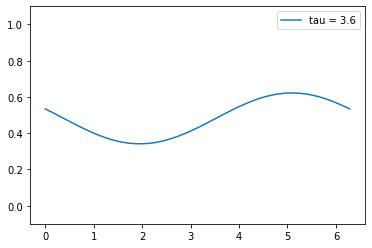

tau = 3.7 ms


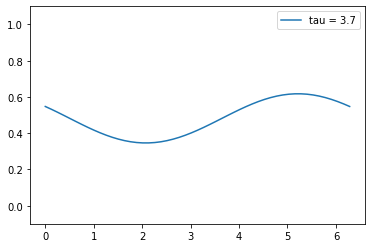

tau = 3.8000000000000003 ms


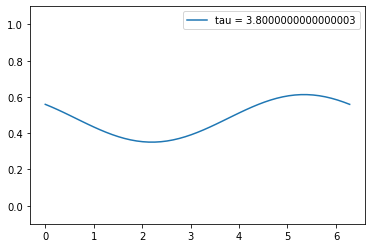

tau = 3.9000000000000004 ms


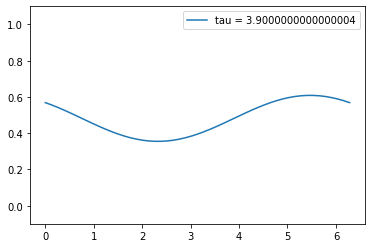

tau = 4.0 ms


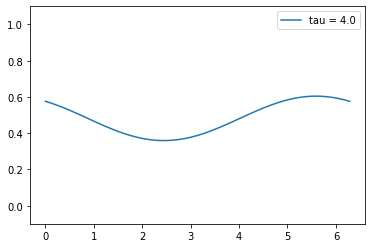

time used: 0:01:54.008788s


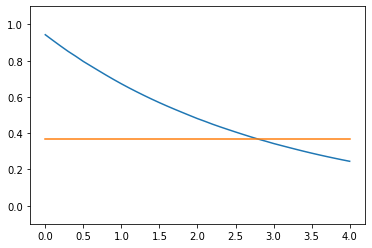

In [36]:
scan_wait_time_and_phase()